In [1]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.naive_bayes import GaussianNB
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import preprocessing
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale,RobustScaler,StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
import sklearn.metrics as metrics
import sklearn.metrics as metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, accuracy_score

In [2]:
raw = pd.read_csv('cleaned.csv')
raw.head()

,title,runtime,imdb_score,imdb_votes,user_review_count,critic_review_count,critic_overall_score,critic_positive_score,critic_mixed_score,critic_negative_score,user_overall_score,user_positive_score,user_mixed_score,user_negative_score,#_of_nominations,#_of_wins
0,10,122.0,6.1,17623.0,82.0,51.0,68.0,4.0,1.0,2.0,5.8,3.0,2.0,1.0,2,0
1,12,159.0,7.6,14601.0,42.0,71.0,72.0,12.0,5.0,0.0,7.4,17.0,1.0,3.0,1,0
2,12 Angry Men,96.0,9.0,759612.0,1900.0,150.0,96.0,10.0,0.0,0.0,9.0,484.0,9.0,22.0,3,0
3,12 Monkeys,129.0,8.0,606901.0,722.0,197.0,74.0,16.0,4.0,0.0,8.7,453.0,30.0,12.0,2,0
4,127 Hours,94.0,7.6,369917.0,533.0,453.0,82.0,37.0,1.0,0.0,8.1,621.0,65.0,25.0,6,0


In [3]:
train, test = train_test_split(raw, test_size=0.25)

In [4]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
titles = list(train['title'])
le.fit(titles)
encoded_titles = le.transform(titles)
train['title'] = encoded_titles

# example of a normalization
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
columns = ['title','runtime', 'imdb_score', 'imdb_votes', 'user_review_count', 'critic_review_count','critic_overall_score','critic_positive_score','critic_mixed_score','critic_negative_score','user_overall_score','user_positive_score','user_mixed_score','user_negative_score','#_of_nominations','#_of_wins']

# convert numerical-object to numericals
for col in columns:
    train[col] = train[col].replace('[^.0-9]', '', regex=True,).astype(float).fillna(0.0)

    # clean textual classes
for col in train.select_dtypes(include='object').columns:
    train[col] = train[col].str.upper().replace('Z_','',regex=True).replace('[^A-Z]','',regex=True)
        
data_types = {f:t for f,t in zip(train.columns,train.dtypes)}

# copy df
df = train.copy()
df = df.drop(labels=['title'],axis=1)
df = df.drop(labels=['#_of_wins'],axis=1)

data_meta = pd.DataFrame(df.nunique(),columns=['num'],index=None).sort_values('num').reset_index()
data_meta.columns = ['name','num']
data_meta['type'] = 'numerical'
#print(data_meta)


#data_meta.loc[(data_meta['num']<=15) & (~data_meta['name'].isin(['category','name','winner'])),'type']='categorical'
data_meta.loc[data_meta['name'].isin(['category','name']),'type']='categorical'

categorical_features = list(data_meta.loc[data_meta['type']=='categorical','name'])
numerical_features = list(data_meta.loc[data_meta['type']=='numerical','name'])
#print(numerical_features)


# Standard Scaled "mean normalisation"
scaler = StandardScaler()
scaler.fit(df[numerical_features])
#print("Feature Means:\t",[f"{x:.2}" for x in scaler.mean_])
numerical_data = scaler.transform(df[numerical_features])
numerical_data = pd.DataFrame(numerical_data,index=df.index,columns=numerical_features)
numerical_data[:2]



scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df[numerical_features])
numerical_data = scaler.transform(df[numerical_features])
numerical_data = pd.DataFrame(numerical_data,index=df.index,columns=numerical_features)
numerical_data[:2]


nominal_features = [c for c in categorical_features]
print("Nominals:\n",nominal_features)

nominal_data = list()
for i,x in df[nominal_features].nunique().iteritems():
    if x <= 2:
        nominal_data.append(pd.get_dummies(df[[i]],drop_first=True))
    elif x > 2:
        nominal_data.append(pd.get_dummies(df[[i]],drop_first=False))
        
#nominal_data = pd.concat(nominal_data,axis=1)

# transformed and scaled dataset
Xy_scaled = pd.concat([numerical_data],axis=1)
#print(f'Data min:max {Xy_scaled.min().min(),Xy_scaled.max().max()}')

# original data
Xy_original = df[numerical_features].copy()

Nominals:
 []


In [5]:
#reducing dimension using PCA.
#calculates the % of the data we still have of our original
pca_2 = PCA(n_components=2)
pca_2result=pca_2.fit_transform(Xy_scaled)
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))

Explained variation per principal component: [0.44140044 0.18407856]
Cumulative variance explained by 2 principal components: 62.55%


In [6]:
# candidate values for our cluster
candidate_values = [2,3,4,5,6]

# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': candidate_values})

In [7]:
pred = test

titles_pred = list(pred['title'])
le.fit(titles_pred)
titles_pred = le.transform(titles_pred)
pred['title'] = titles_pred


columns_pred = ['title','runtime', 'imdb_score', 'imdb_votes', 'user_review_count', 'critic_review_count','critic_overall_score','critic_positive_score','critic_mixed_score','critic_negative_score','user_overall_score','user_positive_score','user_mixed_score','user_negative_score','#_of_nominations','#_of_wins']


    
for col in columns_pred:
    pred[col] = pred[col].replace('[^.0-9]', '', regex=True,).astype(float).fillna(0.0)

    

for col in pred.select_dtypes(include='object').columns:
        pred[col] = pred[col].str.upper().replace('Z_','',regex=True).replace('[^A-Z]','',regex=True)

dp = pred.copy()
dp = dp.drop(labels=['title'],axis=1)
dp = dp.drop(labels=['#_of_wins'],axis=1)

#print(data_count)
data_count_dp = pd.DataFrame(dp.nunique(),columns=['num'],index=None).sort_values('num').reset_index()
data_count_dp.columns = ['name','num']
data_count_dp['type'] = 'numerical'

#data_count_dp.loc[data_count_dp['name'].isin(['category']),'type']='nominal'

nominal_features_dp = list(data_count_dp.loc[data_count_dp['type']=='nominal','name'])
numerical_features_dp = list(data_count_dp.loc[data_count_dp['type']=='numerical','name'])

scaler_dp = StandardScaler()
scaler_dp.fit(dp[numerical_features_dp])
#print("Feature Means:\t",[f"{x:.2}" for x in scaler_dp.mean_])
numerical_data_dp = scaler_dp.transform(dp[numerical_features_dp])
numerical_data_dp = pd.DataFrame(numerical_data_dp,index=dp.index,columns=numerical_features_dp)
numerical_data_dp[:2]

scaler_dp = MinMaxScaler(feature_range=(0,1))
scaler_dp.fit(dp[numerical_features_dp])
numerical_data_dp = scaler_dp.transform(dp[numerical_features_dp])
numerical_data_dp = pd.DataFrame(numerical_data_dp,index=dp.index,columns=numerical_features_dp)


# transformed and scaled dataset
Xy_scaled_dp = pd.concat([numerical_data_dp],axis=1)
#print(f'Data min:max {Xy_scaled.min().min(),Xy_scaled.max().max()}')

#print(Xy_scaled_dp.shape)
# original data
Xy_original_dp = dp[numerical_features_dp].copy()

column_names_dp = Xy_scaled_dp.columns.values
column_names_dp.shape

(14,)

In [8]:
#reducing dimension using PCA.
#calculates the % of the data we still have of our original
pca_3 = PCA(n_components=2)
pca_3result=pca_2.fit_transform(Xy_scaled_dp)
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))

Explained variation per principal component: [0.38283446 0.19595825]
Cumulative variance explained by 2 principal components: 57.88%


In [9]:

train = train['#_of_wins']


train2 = test['#_of_wins']

X_train = pca_2result
y_train = np.array(train)

X_test = pca_3result
y_test = np.array(train2)

In [18]:
y_train2=[]
for i in range(len(y_train)):
    if y_train[i]==0:
        y_train2.append(0)
    else:
        y_train2.append(1)
        
        
y_test2=[]
for i in range(len(y_test)):
    if y_test[i]==0:
        y_test2.append(0)
    else:
        y_test2.append(1)


In [11]:
# Create the SVM
svm = SVC(random_state=42, kernel='linear')

In [19]:
# Fit the data to the SVM classifier
svm = svm.fit(X_train, y_train2)

C:\Users\kjcox\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


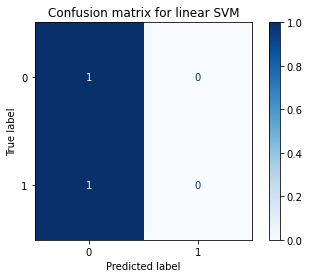

In [20]:
# Evaluate by means of a confusion matrix
matrix = plot_confusion_matrix(svm, X_test, y_test2,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for linear SVM')
plt.show(matrix)
plt.show()

In [21]:
# Generate predictions
y_pred = svm.predict(X_test)

In [22]:
# Evaluate by means of accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Model accuracy: {accuracy}')

Model accuracy: 0.5988023952095808


C:\Users\kjcox\anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:243: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels,


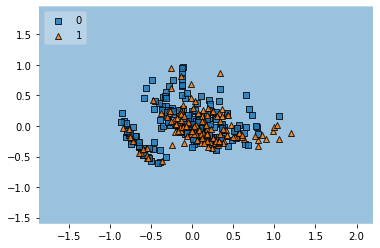

In [27]:
from mlxtend.plotting import plot_decision_regions
# Plot decision boundary
y_test2 = np.array(y_test2)
plot_decision_regions(X_test, y_test2, clf=svm, legend=2)
plt.show()